# Data Analysis of the Ford GoBike's trip data
The public trip data of bike rides.


[The Data](https://www.fordgobike.com/system-data)  
Each trip is anonymized and includes:
* Trip Duration (seconds)
* Start Time and Date
* End Time and Date
* Start Station ID
* Start Station Name
* Start Station Latitude
* Start Station Longitude
* End Station ID
* End Station Name
* End Station Latitude
* End Station Longitude
* Bike ID
* User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)
* Member Year of Birth
* Member Gender



In [1]:
import requests
import os, sys
import re
import pandas as pd
import numpy as np
import zipfile
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
DOWNLOADS_DIR = 'downloads'
DATA_DIR = 'data'
IMAGES_DIR = 'images'

def ensure_dir(file_path=DOWNLOADS_DIR):
    """
    Ensure directory exists or create it.
    :param file_path: directory path
    :return: 
    """
    if not os.path.exists(file_path):
        os.makedirs(file_path)

        
def download(*urls):
    """
    Download files from the provided URL.
    :param urls: variable number of URL
    :return: None
    """
    ensure_dir()
    for url in urls:
        url_file = os.path.join(DOWNLOADS_DIR, url.split(os.path.sep)[-1]).replace('-', '_')
        if not os.path.exists(url_file):
            response = requests.get(url, allow_redirects=True)
            with open(url_file, 'wb') as handle:
                handle.write(response.content)
                sys.stdout.write('.')
    sys.stdout.write('\n')


def download_img(name, url):
    """
    Download image from the provided URL
    :param name: name of image file
    :param url: URL for image
    :return: None
    """
    ensure_dir(IMAGES_DIR)
    image_file = os.path.join(IMAGES_DIR, f"{name}.{url.split('.')[-1]}")
    if not os.path.exists(image_file):
        response = requests.get(url, allow_redirects=True)
        with open(image_file, 'wb') as handle:
            handle.write(response.content)


def extract_zip(file, path=DATA_DIR):
    """
    Extract alla files from a zip archive.
    :param file: file name of archive.
    :param path: target directory for unzipped files.
    :return: a list of file names in the archive.
    """
    with zipfile.ZipFile(os.path.join(DOWNLOADS_DIR, file), 'r') as zip_ref:
        zip_ref.extractall(path)
        return zip_ref.namelist()

def rename(file_from, file_to, directory=DOWNLOADS_DIR):
    """
    Rename file in the 
    :param file_from: Existing file to rename
    :param file_to: Target file name
    :param directory: Source directory, defaults to DOWNLOADS_DIR
    :return: None
    """
    source = os.path.join(directory, file_from)
    if os.path.exists(source):
        os.rename(source, os.path.join(directory, file_to))


def file_exists(filename, directory=DOWNLOADS_DIR):
    """
    Check if the file exists in a optional provided directory.
    :param filename: name of file
    :param directory: Source directory, defaults to DOWNLOADS_DIR
    :return: True if file exists.
    """
    return os.path.exists(os.path.join(directory, filename))

## Gather

In [19]:
download('https://s3.amazonaws.com/fordgobike-data/201801-fordgobike-tripdata.csv.zip', 
        'https://s3.amazonaws.com/fordgobike-data/201802-fordgobike-tripdata.csv.zip', 
        'https://s3.amazonaws.com/fordgobike-data/201803-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201804-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201805-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201806-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201807-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201808-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201809-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201810-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201811-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201812-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201901-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201902-fordgobike-tripdata.csv.zip')

..............


In [20]:
for file in os.listdir(DOWNLOADS_DIR):
    print(file)

201801_fordgobike_tripdata.csv.zip
201812_fordgobike_tripdata.csv.zip
201804_fordgobike_tripdata.csv.zip
201805_fordgobike_tripdata.csv.zip
201901_fordgobike_tripdata.csv.zip
201809_fordgobike_tripdata.csv.zip
201902_fordgobike_tripdata.csv.zip
201803_fordgobike_tripdata.csv.zip
201810_fordgobike_tripdata.csv.zip
201806_fordgobike_tripdata.csv.zip
201808_fordgobike_tripdata.csv.zip
201811_fordgobike_tripdata.csv.zip
201807_fordgobike_tripdata.csv.zip
201802_fordgobike_tripdata.csv.zip


In [22]:
zip_files = [file for file in os.listdir(DOWNLOADS_DIR) if file.endswith('.zip') and os.path.isfile(os.path.join(DOWNLOADS_DIR, file))]

In [23]:
for file in zip_files:
    extract_zip(file, DATA_DIR)
for file in os.listdir(DATA_DIR):
    print(file)

201802-fordgobike-tripdata.csv
201811-fordgobike-tripdata.csv
201809-fordgobike-tripdata.csv
201806-fordgobike-tripdata.csv
201805-fordgobike-tripdata.csv
201812-fordgobike-tripdata.csv
201801-fordgobike-tripdata.csv
201901-fordgobike-tripdata.csv
201807-fordgobike-tripdata.csv
201808-fordgobike-tripdata.csv
201810-fordgobike-tripdata.csv
201803-fordgobike-tripdata.csv
201804-fordgobike-tripdata.csv
201902-fordgobike-tripdata.csv


In [40]:
tripdata_files = [file for file in os.listdir(DATA_DIR) if file.endswith('.csv') and os.path.isfile(os.path.join(DATA_DIR, file))]

## Assess

Quality issues in data source
* start_time - parse as datetime
* end_time - parse as datetime
* member_birth_year - seems to be optional and several member are over 100 years old

In [41]:
dataframes = [pd.read_csv(os.path.join(DATA_DIR, file)) for file in tripdata_files]

bikeshare_df = pd.concat(dataframes)
del tripdata_files
del dataframes
bikeshare_df.shape

(2239215, 16)

In [42]:
bikeshare_df.isnull().sum()

duration_sec                    0
start_time                      0
end_time                        0
start_station_id            12216
start_station_name          12216
start_station_latitude          0
start_station_longitude         0
end_station_id              12216
end_station_name            12216
end_station_latitude            0
end_station_longitude           0
bike_id                         0
user_type                       0
member_birth_year          128703
member_gender              128349
bike_share_for_all_trip         0
dtype: int64

In [14]:
bikeshare_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2239215 entries, 0 to 183411
Data columns (total 16 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
member_birth_year          float64
member_gender              object
bike_share_for_all_trip    object
dtypes: float64(7), int64(2), object(7)
memory usage: 290.4+ MB


In [47]:
print(f"Customer born in range from min: {bikeshare_df['member_birth_year'].min()} - max: {bikeshare_df['member_birth_year'].dropna().max()}")
bikeshare_df.query("member_birth_year < 1910")['member_birth_year'].value_counts()

Customer born in range from min: 1878.0 - max: 2001.0


1900.0    751
1902.0    192
1901.0     44
1888.0     23
1904.0     12
1881.0      5
1909.0      4
1889.0      3
1906.0      2
1903.0      1
1878.0      1
Name: member_birth_year, dtype: int64

## Clean

Define:
* __start_time__ and __end_time__ parse as datetime

Code and Test

In [37]:
bikeshare_df['start_time'] = pd.to_datetime(bikeshare_df['start_time'])
bikeshare_df['end_time'] = pd.to_datetime(bikeshare_df['end_time'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2239215 entries, 0 to 183411
Data columns (total 16 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
member_birth_year          object
member_gender              object
bike_share_for_all_trip    object
dtypes: datetime64[ns](2), float64(6), int64(2), object(6)
memory usage: 290.4+ MB


min: 1878.0 - max: 2001.0


## Exploratory Data Analysis

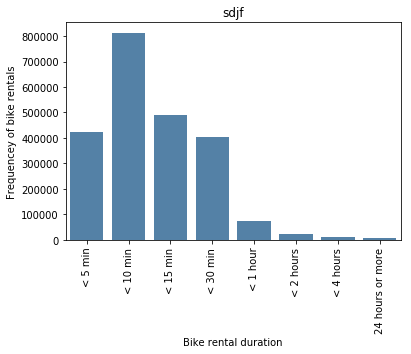

In [92]:
bins = [0, 300, 600, 900, 1800, 3600, 7200, 14400, 86400]
labels = ['< 5 min', '< 10 min', '< 15 min', '< 30 min', '< 1 hour', '< 2 hours', '< 4 hours', '24 hours or more']

duration_quartiles = pd.cut(bikeshare_df['duration_sec'], bins=bins, labels=labels)
binned_duration = duration_quartiles.value_counts(sort=False)
#binned_duration.columns = ['duration', 'sum']
ax = sns.barplot(binned_duration.index, binned_duration, color='steelblue')
ax.set(title='sdjf', xlabel='Bike rental duration', ylabel='Frequencey of bike rentals')
ax.tick_params(axis='x', labelrotation=90)

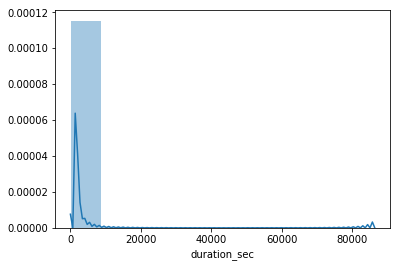

In [53]:
sns.distplot(bikeshare_df['duration_sec'], bins=10)

In [ ]:
## Explainatory Data Analysis